### aim: 

We have monthly overturning files and a depth profile of DIC. we want to know - how much extra DIC 

### date: 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

In [4]:
scendict = {
    '1A': {
        'hist_str': 'bc370',
        'fut_str': 'be682',
        'name': 'HIST.OZONE \n LOW TEMP.',
        'name2':'1A: NatlOzone-SSP126',
        'color':'#E8D215',
        'color2':'orange'},
    '1B': {
        'hist_str': 'bc370',
        'fut_str': 'ce417',
        'name': 'HIST. OZONE \n HIGH TEMP.',
        'name2':'1B: NatlOzone-SSP370',
        'color':'#87800A',
        'color2':'orangered'},
    '2A': {
        'hist_str': 'cj198',
        'fut_str': 'cj880',
        'name': 'FIXED OZONE \n LOW TEMP.',
        'name2':'2A: Ozone1950-SSP126',
        'color':'#2DC18E',
        'color2':'mediumseagreen'},
    '2B': {
        'hist_str': 'cj198',
        'fut_str': 'cj881',
        'name': 'FIXED OZONE \n HIGH TEMP.',
        'name2':'2B: Ozone1950-SSP370',
        'color':'#18765C',
        'color2':'green'},
    '3A': {
        'hist_str': 'cj200',
        'fut_str': 'cj484',
        'name': '1990 OZONE \n LOW TEMP.',
        'name2':'3A: Ozone1990-SSP126',
        'color':'#FF462B',
        'color2':'dodgerblue'},
    '3B': {
        'hist_str': 'cj200',
        'fut_str': 'cj504',
        'name': '1990 OZONE \n HIGH TEMP.',
        'name2':'3B: Ozone1990-SSP370',
        'color':'#822722',
        'color2':'mediumblue'}
}

In [5]:
def make_yearfiles_ukesm(yrst, yren, tscen, sig = False):
    #print(f'SCENARIO {tscen}')
    dslist = []
    
    tdir = '/gpfs/data/greenocean/software/resources/MEDUSA/ukesm_allscen_moc_byyear/'
    
    for y in range(yrst,yren):
        if ((y<1990) & ((tscen == '3A') | (tscen == '3B'))):
            tstr = scendict['1A']['hist_str']
        elif y<2015:
            tstr = scendict[tscen]['hist_str']

        else:
            tstr = scendict[tscen]['fut_str']
        try:
            if sig:
                td = glob.glob(f'{tdir}/nemo_{tstr}o_1y_{y}_mocsig.nc')
            else:
                td = glob.glob(f'{tdir}/nemo_{tstr}o_1y_{y}_moc.nc')
            dslist.append(td[0])
            if (len(td) != 1):
                print(f'SCENARIO {tscen}, {y}, something missing')

        except:
            pass

    return dslist


In [6]:
s1A_1950_1960_mocf = make_yearfiles_ukesm(1950, 1960, '1A', sig = False)
s1A_1950_1960_mocsigf = make_yearfiles_ukesm(1950, 1960, '1A', sig = True)

In [7]:
s1A_1950_1960_mocf

['/gpfs/data/greenocean/software/resources/MEDUSA/ukesm_allscen_moc_byyear//nemo_bc370o_1y_1950_moc.nc',
 '/gpfs/data/greenocean/software/resources/MEDUSA/ukesm_allscen_moc_byyear//nemo_bc370o_1y_1951_moc.nc',
 '/gpfs/data/greenocean/software/resources/MEDUSA/ukesm_allscen_moc_byyear//nemo_bc370o_1y_1952_moc.nc',
 '/gpfs/data/greenocean/software/resources/MEDUSA/ukesm_allscen_moc_byyear//nemo_bc370o_1y_1953_moc.nc',
 '/gpfs/data/greenocean/software/resources/MEDUSA/ukesm_allscen_moc_byyear//nemo_bc370o_1y_1954_moc.nc',
 '/gpfs/data/greenocean/software/resources/MEDUSA/ukesm_allscen_moc_byyear//nemo_bc370o_1y_1955_moc.nc',
 '/gpfs/data/greenocean/software/resources/MEDUSA/ukesm_allscen_moc_byyear//nemo_bc370o_1y_1956_moc.nc',
 '/gpfs/data/greenocean/software/resources/MEDUSA/ukesm_allscen_moc_byyear//nemo_bc370o_1y_1957_moc.nc',
 '/gpfs/data/greenocean/software/resources/MEDUSA/ukesm_allscen_moc_byyear//nemo_bc370o_1y_1958_moc.nc',
 '/gpfs/data/greenocean/software/resources/MEDUSA/ukesm

In [10]:
w = xr.open_dataset(s1A_1950_1960_mocf[0])
ws = xr.open_dataset(s1A_1950_1960_mocsigf[0])

Text(0.5, 1.04, 'Scenario 1A overturning in depth and sigma coordinates, 1950-1960 mean')

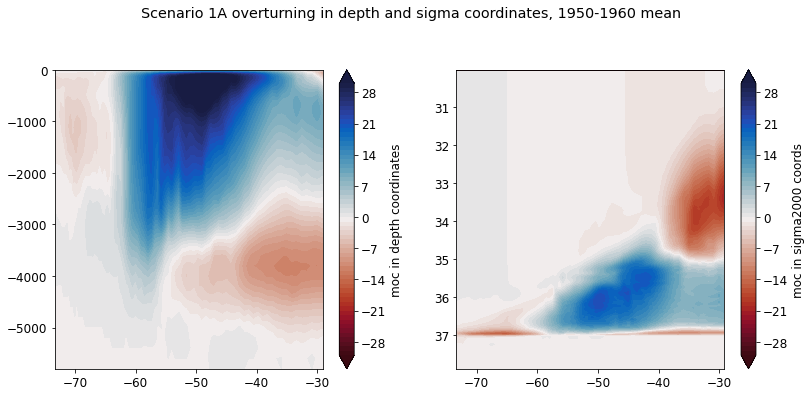

In [32]:
def get_mean_moc(mocf):
    tdat = xr.open_mfdataset(mocf)
    mn = tdat.zomsfglo.sel(y=slice(60,141)).mean(dim = ['time_counter']).mean(dim = ['x'])

    return mn
    
def get_mean_mocsig(mocf):
    tdat = xr.open_mfdataset(mocf)
    mn = tdat.dmoc2000.isel(latV=slice(60,141)).mean(dim = ['time_counter'])

    return mn

def plot_moc(ind, mocfil, vmin = -31, vmax = 31):
    w = axs[ind].contourf(tLat[60:141], mocfil.depthw, mocfil.values, np.arange(vmin, vmax, 1), cmap = cm.balance_r, extend = "both")
    plt.colorbar(w, ax = axs[ind], label = 'moc in depth coordinates')
    
def plot_mocsig(ind, mocfil, vmin = -31, vmax = 31):
    w = axs[ind].contourf(mocfil.latV, mocfil.sigma2000, mocfil.values, np.arange(vmin, vmax, 1), cmap = cm.balance_r, extend = "both")
    plt.colorbar(w, ax = axs[ind], label = 'moc in sigma2000 coords')
    # print(mocfil.sigma2000)
    axs[ind].invert_yaxis()
    
tdat = xr.open_mfdataset(s1A_1950_1960_mocsigf)
tLat = tdat.latV.values
tlatind = np.arange(60,141,20)
tLatpl = (tLat[tlatind]).astype(int)

tlatind_min60 = tlatind-60
    
s1A_1950_1960_moc_mn = get_mean_moc(s1A_1950_1960_mocf)
s1A_1950_1960_mocsig_mn = get_mean_mocsig(s1A_1950_1960_mocsigf)
    
fact = 1.1
fig, axs = plt.subplots(1,2, figsize=(12*fact, 5*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

plot_moc(0,s1A_1950_1960_moc_mn)
plot_mocsig(1,s1A_1950_1960_mocsig_mn)


plt.suptitle('Scenario 1A overturning in depth and sigma coordinates, 1950-1960 mean', y = 1.04)

#xr.plot.pcolormesh(s1A_1950_1960_mocsig_mn, ax = axs[1])
# axs[1].set_xticks(tlatind_min60)
# q = axs[1].set_xticklabels(tLatpl)

Text(0.5, 1.0, 'medusa_cj484o_1m_20631001-20631101_ptrc-T.nc 0,:,70,120, DIC')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


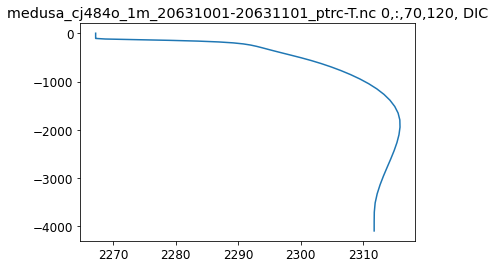

In [28]:
w2 = xr.open_dataset('/gpfs/data/greenocean/software/resources/MEDUSA/ukesm_allscen_ptrcT_TADIC/medusa_cj484o_1m_20631001-20631101_ptrc-T.nc')

w2

plt.plot(w2.DIC[0,:,70,120], -w2.deptht)
plt.title('medusa_cj484o_1m_20631001-20631101_ptrc-T.nc 0,:,70,120, DIC')

In [22]:
print(w2.DIC[:,:,70,120])

<xarray.DataArray 'DIC' (time_counter: 1, deptht: 75)>
array([[2267.2031, 2267.203 , 2267.203 , 2267.203 , 2267.203 , 2267.203 ,
        2267.203 , 2267.203 , 2267.203 , 2267.203 , 2267.203 , 2267.203 ,
        2267.203 , 2267.203 , 2267.203 , 2267.203 , 2267.203 , 2267.2026,
        2267.2026, 2267.2026, 2267.2026, 2267.2026, 2267.2026, 2267.2031,
        2267.2087, 2268.7551, 2273.5713, 2279.019 , 2283.5596, 2286.8853,
        2289.2021, 2290.8127, 2291.9836, 2292.9336, 2293.8313, 2294.791 ,
        2295.882 , 2297.1309, 2298.5435, 2300.087 , 2301.6812, 2303.278 ,
        2304.8672, 2306.44  , 2307.9841, 2309.4785, 2310.891 , 2312.185 ,
        2313.326 , 2314.2893, 2315.0527, 2315.5881, 2315.8674, 2315.895 ,
        2315.7322, 2315.4094, 2314.961 , 2314.4233, 2313.838 , 2313.2495,
        2312.7036, 2312.2427, 2311.9194, 2311.7815, 2311.7617, 2311.761 ,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan]], dtype=float32)